This image is: <class 'numpy.ndarray'> with dimensions: (224, 224, 3)


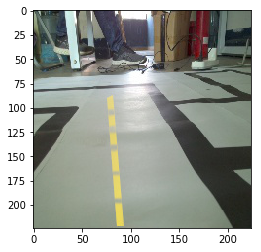

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
# reading in an image
image = mpimg.imread('road.jpg')
# printing out some stats and plotting the image
print('This image is:', type(image), 'with dimensions:', image.shape)

plt.imshow(image)
plt.show()


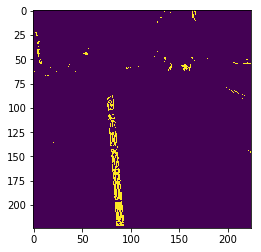

In [14]:
def color_filter(img):
    """
    将图像灰度化，作为后续边缘检测的预处理
    """
    lower_hsv = np.array([26, 43, 46])
    upper_hsv = np.array([34,255,255])
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    return cv2.inRange(img_hsv, lower_hsv, upper_hsv)

gray_img=color_filter(image)

plt.imshow(gray_img)

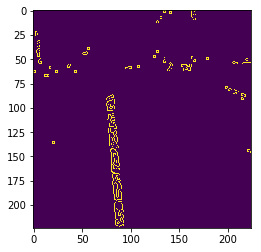

In [15]:
def canny(img,low_threshold=100,high_threshold=200):
        """
        input是经过灰度处理的灰度图像，不关注颜色，只关注颜色强度
        边缘检测，原理：计算颜色值的梯度和方向，找到梯度变化较大的像素
        >high_threshold: edge
        <low_threshold:not edge
        中间值：若与edge相连，则认为是edge,不相连则not edge
        """
        return cv2.Canny(img,low_threshold,high_threshold)
canny_img=canny(gray_img)
plt.imshow(canny_img)


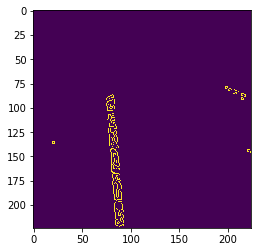

In [16]:
def region_of_interest(img):
        """
        分割出ROI，并填充，再对图像掩膜处理，将其他object遮挡
        """
        #draw the polygon with three vertices
        height=img.shape[0]
        width=img.shape[1]
        region_of_interest_vertices = [
        (0, height),
        (0, height / 3),
        (width, height / 3),
        (width, height)]
        # Define a blank matrix that matches the image height/width.
        mask = np.zeros_like(img)
        # Retrieve the number of color channels of the image.
        #channel_count = img.shape[2]
        # Create a match color with the same color channel counts.
        #match_mask_color = (255,) * channel_count #彩色图像时的color
        match_mask_color = 255
        # Fill inside the polygon
        #cv2.fillPoly(mask, np.array([region_of_interest_vertices],np.int32)，match_mask_color)#多边形填充
        cv2.fillPoly(mask, np.array([region_of_interest_vertices],np.int32), match_mask_color)
        #按位与操作，对图片进行mask淹膜操作，ROI区域正常显示，其他区域置零
        masked_image = cv2.bitwise_and(img, mask) 
        return masked_image
ROI_img=region_of_interest(canny_img)
plt.imshow(ROI_img)


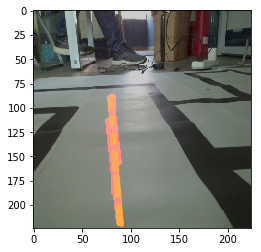

In [18]:
def hough_lines(img,rho=6,theta=np.pi/180,threshold=160,
                    min_line_len=40,max_line_gap=25):
        """
        将canny边缘检测后的像素点连接成线，并调用划线函数，返回画线的图片
        hough transform原理：转换到 hough space,r,θ极坐标，正弦曲线，
        每条线代表个image space中过一点的所有线，
        lines的交点代表共线，找到交点再返回到image space空间
        lines:[[x1,y1,x2,y2],[x x y y]...]
        """
        lines=cv2.HoughLinesP(img,rho,theta,threshold, np.array([]), 
                              minLineLength=min_line_len, maxLineGap=max_line_gap)
        return lines
    
def draw_lines(img,lines,color=[255,0,0],thickness=3):
    """
    生成一个zeros图划线，并与原图混合
    """
    if lines is None:
        return
    img=np.copy(img)
    #生成待划线的图,zeros，addweighted混合的时候，0值不会显示
    img_channels=img.shape[2]
    line_img=np.zeros((img.shape[0],img.shape[1],img_channels),dtype=np.uint8)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_img,(x1,y1),(x2,y2),color,thickness)
    #将划线图与原图合并
    #cv2.addWeighted(initial_img, α, img, β , γ) 
    #output: initial_img * α + img * β + γ
    img=cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0) #叠加的两幅图片尺寸和channel需要一致
    return img
 
lines=hough_lines(ROI_img)
line_img=draw_lines(image,lines)
plt.imshow(line_img)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in int_scalars
  # This is added back by InteractiveShellApp.init_path()


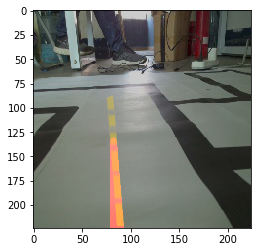

In [19]:
def group_lines_and_draw(img,lines):
    """
    根据斜率，将所有的线分为左右两组,斜率绝对值小于0.5的舍去（影响不显著）
    （因为图像的原点在左上角，slope<0是left lines，slope>0是right lines)
    设定min_y作为left和right的top线,max_y为bottom线，求出四个x值即可确定直线：
    将left和right的点分别线性拟合，拟合方程根据y值，求出x值，画出lane
    """
    left_x,left_y,right_x,right_y=[],[],[],[]
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope=(y2-y1)/(x2-x1)
            if abs(slope)<0.5: continue
            if slope<0:
                left_x.extend([x1,x2])
                left_y.extend([y1,y2])
            if slope>0:
                right_x.extend([x1,x2])
                right_y.extend([y1,y2])
    #设定top 和 bottom的y值，left和right的y值都一样
    min_y=int(img.shape[0]*(3/5))
    max_y=int(img.shape[0])

    #对left的所有点进行线性拟合
    poly_left = np.poly1d(np.polyfit(left_y,left_x,deg=1))
    left_x_start = int(poly_left(max_y))
    left_x_end = int(poly_left(min_y))
    
    #对right的所有点进行线性拟合
    poly_right = np.poly1d(np.polyfit(right_y,right_x,deg=1))
    right_x_start = int(poly_right(max_y))
    right_x_end = int(poly_right(min_y))

    line_image=draw_lines(img,[[
            [left_x_start,max_y,left_x_end,min_y],
            [right_x_start,max_y,right_x_end,min_y],          
            ]],thickness=5)
    return line_image
 
final_image=group_lines_and_draw(image,lines)
plt.imshow(final_image)